# Calibration

To study the calibration of neural network models

In [1]:
import os
import argparse
import yaml
import numpy as np
from sklearn.metrics import average_precision_score
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
from torch import nn, optim
import torch.nn.functional as F
%matplotlib inline

import sys
sys.path.insert(0, '../')
from loaders import get_loader
from learners import get_learner
from models import get_model
from utils import trust_scores
from metrics import Metrics
import utils.logger
LOGGER = utils.logger.get_logger(__name__, level='DEBUG')

## Load normal model

In [2]:
config_path = '/share/DEEPLEARNING/ccorbiere/logs/camvid/camvid_segnet_baseline_pretrained_dropout/config_1.yaml'
epoch = 326
mode = 'normal'
start_epoch = 1

# cifar100_trustscore_baseline => 270
# cifar10_trustscore_baseline_pretrained =< 197
# paper/mnist_trustscore_baseline => 56
# svhn_trustscore_baseline => 17
# paper/mnist_mlp_baseline_dropout => 130
# camvid_segnet_baseline_pretrained_dropout => 326

# Dataloader
with open(config_path, 'r') as f:
    config_args = yaml.load(f, Loader=yaml.SafeLoader)
    config_args['training']['metrics'] = ['accuracy', 'auc', 'ap_success', 'ap_errors']

config_args['data']['is_test'] = True
config_args['model']['feature_dim'] = 512
   
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
LOGGER.info('Loading dataset {}'.format(config_args['data']['dataset']))
dloader = get_loader(config_args, generating=True)

# Make loaders
dloader.make_loaders()

# Set learner
LOGGER.warning('Learning type: {}'.format(config_args['training']['learner']))
learner_normal = get_learner(config_args, dloader.train_loader, dloader.val_loader, 
                             dloader.test_loader, start_epoch, device)

# Load model
# Initialize and load model
ckpt_path = os.path.join(config_args['training']['output_folder'], 'model_epoch_{:03d}.ckpt'.format(epoch))
checkpoint = torch.load(ckpt_path)
learner_normal.model.load_state_dict(checkpoint['model_state_dict'])

# Get scores
LOGGER.info('Inference mode: {}'.format(mode))

if not hasattr(checkpoint, 'prod_test_len'):
    learner_normal.prod_test_len = learner_normal.nsamples_test

2019-07-27 19:16:01,908 gpuserver2 __main__[7803] INFO Loading dataset camvid
2019-07-27 19:16:01,910 gpuserver2 loaders.loader[7803] INFO --- Augmentations ---
2019-07-27 19:16:01,910 gpuserver2 augmentations[7803] INFO Using hflip aug with params True
2019-07-27 19:16:01,926 gpuserver2 __main__[7803] WARNING Learning type: segmentation


fetched 367 images from text file
fetched 101 images from text file
fetched 233 images from text file


2019-07-27 19:16:04,416 gpuserver2 learners.learner[7803] INFO Using optimizer adam
2019-07-27 19:16:04,963 gpuserver2 __main__[7803] INFO Inference mode: normal


## Load selfconfid model

In [181]:
config_path = '/share/DEEPLEARNING/ccorbiere/logs/camvid/paper/camvid_segnet_selfconfid_k3_adam_lr6_cloning_pretrained_new/config_1.yaml'
epoch = 1

# cifar100_selfconfid_cloning_adam_lr4_pretrained => 162
# cifar10_selfconfid_cloning_adam_lr4_pretrained => 162
# mnist_trustscore_selfconfid_cloning_adam_lr5_pretrained => 11
# svhn_selfconfid_cloning_adam_lr6_mse_pretrained => 2
# mnist_mlp_selfconfid_cloning_adam_lr5_pretrained => 12
# camvid_segnet_selfconfid_k3_adam_lr6_cloning_pretrained_new => 1

with open(config_path, 'r') as f:
    config_args = yaml.load(f, Loader=yaml.SafeLoader)
    config_args['training']['metrics'] = ['accuracy', 'auc', 'ap_success', 'ap_errors']
    if config_args['training']['learner'] in ['segmentation', 'selfconfid-segmentation']:
        config_args['training']['metrics'].append('mean_iou')
        
config_args['model']['feature_dim'] = 512

# Set learner
LOGGER.warning('Learning type: {}'.format(config_args['training']['learner']))
learner_selfconfid = get_learner(config_args, dloader.train_loader, dloader.val_loader, 
                             dloader.test_loader, start_epoch, device)

# Load model
# Initialize and load model
ckpt_path = os.path.join(config_args['training']['output_folder'], 'model_epoch_{:03d}.ckpt'.format(epoch))
checkpoint = torch.load(ckpt_path)
learner_selfconfid.model.load_state_dict(checkpoint['model_state_dict'])

if not hasattr(learner_selfconfid, 'prod_test_len'):
    learner_selfconfid.prod_test_len = learner_selfconfid.nsamples_test

2019-07-27 18:52:09,112 gpuserver2 __main__[3236] WARNING Learning type: selfconfid-segmentation
2019-07-27 18:52:09,642 gpuserver2 learners.learner[3236] INFO Using optimizer adam
2019-07-27 18:52:09,646 gpuserver2 learners.segmentation_selfconfid_learner[3236] INFO Freezing every layer except uncertainty
2019-07-27 18:52:09,649 gpuserver2 learners.segmentation_selfconfid_learner[3236] INFO Keeping original BN parameters


uncertainty_network.down1.conv1.cbr_unit.0.weight kept to training
uncertainty_network.down1.conv1.cbr_unit.0.bias kept to training
uncertainty_network.down1.conv1.cbr_unit.1.weight kept to training
uncertainty_network.down1.conv1.cbr_unit.1.bias kept to training
uncertainty_network.down1.conv2.cbr_unit.0.weight kept to training
uncertainty_network.down1.conv2.cbr_unit.0.bias kept to training
uncertainty_network.down1.conv2.cbr_unit.1.weight kept to training
uncertainty_network.down1.conv2.cbr_unit.1.bias kept to training
uncertainty_network.down2.conv1.cbr_unit.0.weight kept to training
uncertainty_network.down2.conv1.cbr_unit.0.bias kept to training
uncertainty_network.down2.conv1.cbr_unit.1.weight kept to training
uncertainty_network.down2.conv1.cbr_unit.1.bias kept to training
uncertainty_network.down2.conv2.cbr_unit.0.weight kept to training
uncertainty_network.down2.conv2.cbr_unit.0.bias kept to training
uncertainty_network.down2.conv2.cbr_unit.1.weight kept to training
uncertain

## Calibrate model

In [3]:
class _ECELoss(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).
    The input to this loss is the logits of a model, NOT the softmax scores.
    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:
    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |
    We then return a weighted average of the gaps, based on the number
    of samples in each bin
    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece

In [6]:
class ModelWithTemperature(nn.Module):
    """
    A thin decorator, which wraps a model with temperature scaling
    model (nn.Module):
        A classification neural network
        NB: Output of the neural network should be the classification logits,
            NOT the softmax (or log softmax)!
    """
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        """
        Perform temperature scaling on logits
        """
        # Expand temperature to match the size of logits
        #temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1), logits.size(2), logits.size(3))
        return logits / temperature

    # This function probably should live outside of this class, but whatever
    def set_temperature(self, valid_loader):
        """
        Tune the tempearature of the model (using the validation set).
        We're going to set it to optimize NLL.
        valid_loader (DataLoader): validation set loader
        """
        self.cuda()
        nll_criterion = nn.CrossEntropyLoss().cuda()
        ece_criterion = _ECELoss().cuda()

        # First: collect all the logits and labels for the validation set
        logits_list = []
        labels_list = []
        with torch.no_grad():
            for input, label in valid_loader:
                input = input.cuda()
                logits = self.model(input)
                logits_list.append(logits)
                labels_list.append(label)
            logits = torch.cat(logits_list).cuda()
            labels = torch.cat(labels_list).cuda()

        # Calculate NLL and ECE before temperature scaling
        before_temperature_nll = nll_criterion(logits, labels.squeeze(dim=1)).item()
        before_temperature_ece = ece_criterion(logits, labels.squeeze(dim=1)).item()
        print('Before temperature - NLL: %.3f, ECE: %.3f' % (before_temperature_nll, before_temperature_ece))

        # Next: optimize the temperature w.r.t. NLL
        optimizer = optim.LBFGS([self.temperature], lr=0.001, max_iter=50)

        def eval():
            loss = nll_criterion(self.temperature_scale(logits), labels.squeeze(dim=1))
            loss.backward()
            return loss
        optimizer.step(eval)

        # Calculate NLL and ECE after temperature scaling
        after_temperature_nll = nll_criterion(self.temperature_scale(logits), labels.squeeze(dim=1)).item()
        after_temperature_ece = ece_criterion(self.temperature_scale(logits), labels.squeeze(dim=1)).item()
        print('Optimal temperature: %.3f' % self.temperature.item())
        print('After temperature - NLL: %.3f, ECE: %.3f' % (after_temperature_nll, after_temperature_ece))

        return self

In [7]:
# Now we're going to wrap the model with a decorator that adds temperature scaling
model_calibrated = ModelWithTemperature(learner_normal.model)

# Tune the model temperature, and save the results
model_calibrated.set_temperature(dloader.val_loader)

Before temperature - NLL: 0.546, ECE: 0.063
Optimal temperature: 1.568
After temperature - NLL: 0.436, ECE: 0.013


ModelWithTemperature(
  (model): Segnet(
    (down1): segnetDown2(
      (conv1): conv2DBatchNormRelu(
        (cbr_unit): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
        )
      )
      (conv2): conv2DBatchNormRelu(
        (cbr_unit): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
        )
      )
      (maxpool_with_argmax): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (down2): segnetDown2(
      (conv1): conv2DBatchNormRelu(
        (cbr_unit): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=Tr

## Compute predictions

In [8]:
def predict_model(test_loader, model, mode='normal'):
    accuracy = 0
    accurate, proba_pred = [], []

    model.eval()
    with torch.no_grad():
        loop = tqdm(test_loader)
        for j, (data,target) in enumerate(loop):
            data, target = data.to(device), target.to(device)
            if mode=='normal':
                output = model(data)
                if isinstance(output,tuple):
                    output = output[0]
                confidence, pred = F.softmax(output, dim=1).max(dim=1, keepdim=True)
            elif mode=='selfconfid':
                output, confidence = model(data)
                pred = output.argmax(dim=1, keepdim=True)
                confidence = torch.sigmoid(confidence)
            accuracy += pred.eq(target.view_as(pred)).sum()
            accurate.extend(pred.eq(target.view_as(pred)))
            proba_pred.extend(confidence)


    proba_pred = torch.stack(proba_pred).detach().to('cpu') #.numpy()   
    accurate = torch.cat(accurate).detach().to('cpu') #.numpy()

    len_test_set = len(dloader.test_loader.dataset)
    accuracy = accuracy.item() / float(len_test_set)
    print('Test set: Accuracy: {}/{} ({:.2f}%)'.format(
        int(accuracy*len_test_set), len_test_set, 100*accuracy))
    
    return proba_pred, accurate, accuracy

In [9]:
def compute_ece(proba_pred, accurate):
    bin_boundaries = torch.linspace(0, 1, 10 + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    ece = torch.zeros(1, device=device)
    acc_in_bin_list, avg_confidence_in_bin_list = [], []

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated |confidence - accuracy| in each bin
        in_bin = (proba_pred.gt(bin_lower.item()) * proba_pred.le(bin_upper.item())).flatten()
        prop_in_bin = in_bin.float().mean()   
        accuracy_in_bin = accurate.flatten()[in_bin].float().mean()
        avg_confidence_in_bin = proba_pred.flatten()[in_bin].mean()
        acc_in_bin_list.append(accuracy_in_bin)
        avg_confidence_in_bin_list.append(avg_confidence_in_bin)
        if prop_in_bin.item() > 0:
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
            
    return ece, avg_confidence_in_bin_list, acc_in_bin_list

In [10]:
proba_pred_normal, accurate_normal, accuracy_normal = predict_model(dloader.test_loader, learner_normal.model, mode='normal')
ece_normal, avg_confidence_normal, acc_in_bin_normal = compute_ece(proba_pred_normal, accurate_normal)
print('ECE: {:.2%}'.format(ece_normal.detach().cpu().numpy()[0]))


Test set: Accuracy: 34155955/233 (14659208.15%)
ECE: 10.13%


In [287]:
#proba_pred_selfconfid, accurate_selfconfid, accuracy_selfconfid = predict_model(dloader.test_loader, learner_normal.model, mode='selfconfid')
#ece_selfconfid, avg_confidence_selfconfid, acc_in_bin_normal = compute_ece(proba_pred_selfconfid, accurate_selfconfid)
#print('ECE: {:.2%}'.format(ece_selfconfid.detach().cpu().numpy()[0]))

In [11]:
proba_pred_calibrated, accurate_calibrated, accuracy_calibrated = predict_model(dloader.test_loader, model_calibrated)
ece_calibrated, avg_confidence_calibrated, acc_in_bin_calibrated = compute_ece(proba_pred_calibrated, accurate_calibrated)
print('ECE: {:.2%}'.format(ece_calibrated.detach().cpu().numpy()[0]))


Test set: Accuracy: 34155955/233 (14659208.15%)
ECE: 4.77%


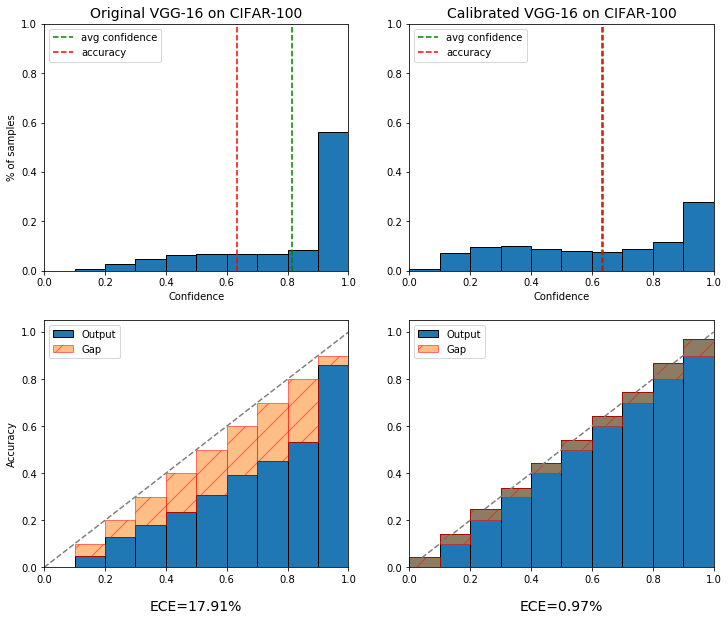

In [16]:
plt.figure(figsize=(12,10))
plt.subplot(221)
plt.title('Original VGG-16 on CIFAR-100', fontsize=14)
plt.hist(proba_pred_normal.flatten(),  weights=np.ones(len(proba_pred_normal)) / len(proba_pred_normal),
         bins=np.linspace(0, 1,num=11), edgecolor='black')
plt.axvline(proba_pred_normal.mean(), color='green', linestyle='--', label='avg confidence')
plt.axvline(accuracy_normal, color='red', linestyle='--', label='accuracy')
plt.xlabel('Confidence')
plt.ylabel('% of samples')
plt.xlim(left=0, right=1)
plt.ylim(0, 1)
plt.legend()

plt.subplot(222)
plt.title('Calibrated VGG-16 on CIFAR-100', fontsize=14)
plt.hist(proba_pred_calibrated.flatten(),  weights=np.ones(len(proba_pred_calibrated)) / len(proba_pred_calibrated),
         bins=np.linspace(0, 1,num=11), edgecolor='black')
plt.axvline(proba_pred_calibrated.mean(), color='green', linestyle='--', label='avg confidence')
plt.axvline(accuracy_calibrated, color='red', linestyle='--', label='accuracy')
plt.xlabel('Confidence')
plt.xlim(left=0, right=1)
plt.ylim(0, 1)
plt.legend()

plt.subplot(223)
plt.bar(np.linspace(0,0.9,10), acc_in_bin_normal, align='edge', 
        width=0.1, edgecolor='black', label='Output')
plt.bar(np.linspace(0,0.9,10), np.linspace(0,0.9,10)-acc_in_bin_normal, bottom=acc_in_bin_normal, 
        align='edge', edgecolor='r', hatch='/', width=0.1, alpha=0.5, label='Gap')
plt.plot(np.linspace(0,1,11), np.linspace(0,1,11), color='grey', linestyle='--')
plt.xlim(left=0, right=1)
plt.ylabel('Accuracy')
plt.title('ECE={:.2%}'.format(ece_normal[0].detach().cpu().numpy()), y=-0.2, fontsize=14)
plt.legend()

plt.subplot(224)
plt.bar(np.linspace(0,0.9,10), acc_in_bin_calibrated, align='edge', 
        width=0.1, edgecolor='black', label='Output')
plt.bar(np.linspace(0,0.9,10), np.linspace(0,0.9,10)-acc_in_bin_calibrated, bottom=acc_in_bin_calibrated, 
        align='edge', edgecolor='r', hatch='/', width=0.1, alpha=0.5, label='Gap')
plt.plot(np.linspace(0,1,11), np.linspace(0,1,11), color='grey', linestyle='--')
plt.xlim(left=0, right=1)
plt.title('ECE={:.2%}'.format(ece_calibrated[0].detach().cpu().numpy()), y=-0.2, fontsize=14)
plt.legend()

plt.show()

## Save calibrated temperature

In [17]:
with open(os.path.join(learner_normal.output_folder, 'temperature_scaling_{:03d}.txt'.format(epoch)), 'w') as file:
    file.write('{:.4f}'.format(model.state_dict()['temperature'].item())) 